In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
url='https://raw.githubusercontent.com/rossetl/Earthquake-Data-Analysis/main/SouthCalifornia-1982-2011_Physics-of-Data.dat'
labels=['#', 'pointer','t', 'mag', 'lat', 'long', 'dep']
df=pd.read_csv(url,sep="\s",names=labels,engine='python') 
df=df.drop(columns=['#'])
c=60*60*24

# $P_{m,R}(t)$ Study

C:\Users\andre\anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
C:\Users\andre\anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


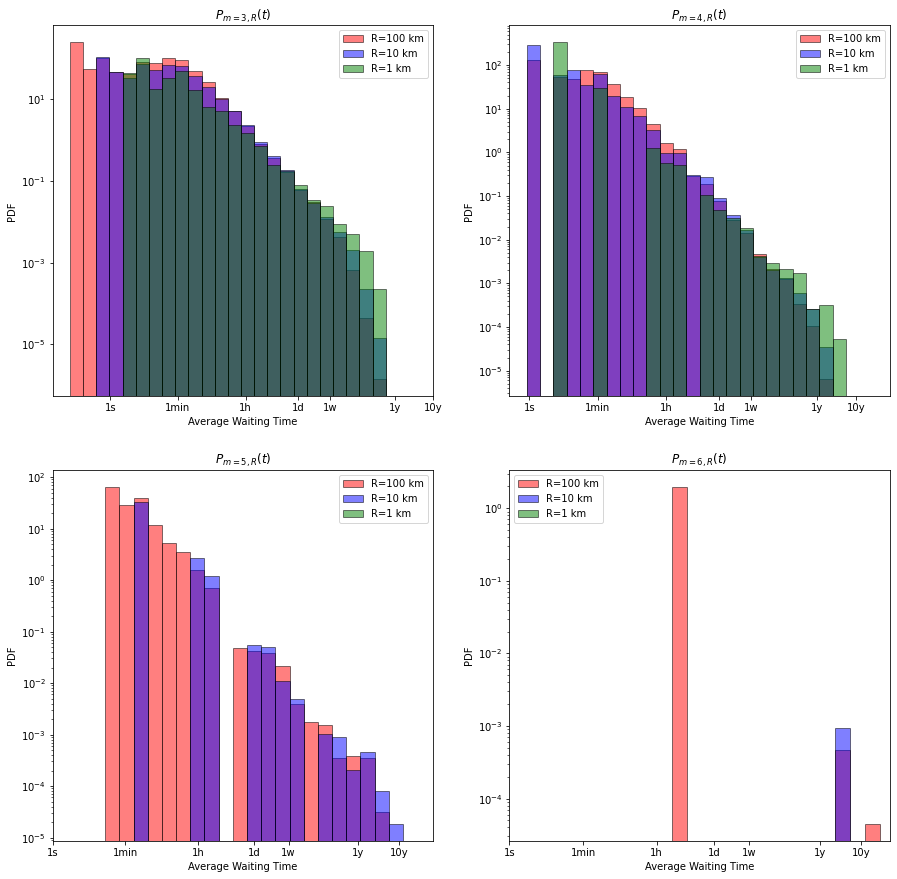

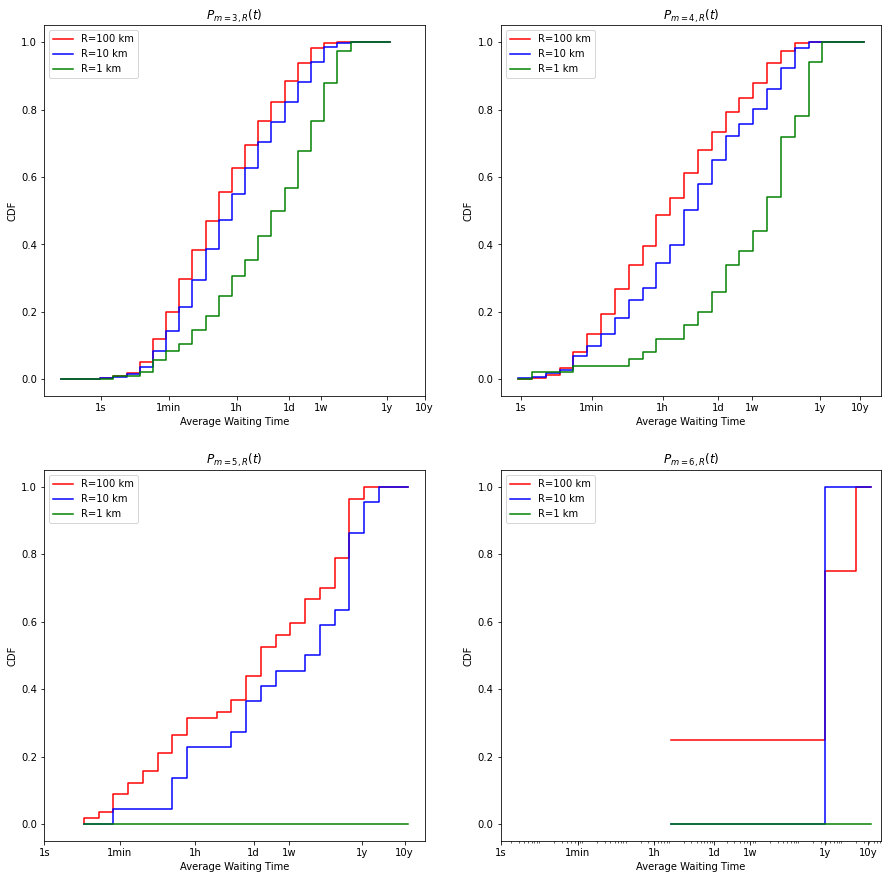

In [2]:
magth=np.arange(3,7,1)
extmv0=np.array([-6,-5,-4,-1])
extmv1=np.array([3,4,4,4])
ncpd=4 #number of class per decade
num_bins=np.array([9,9,8,5])*(ncpd-1) 
#num_bins=40
R=np.matrix('100000 100000 100000 100000;10000 10000 10000 10000;1000 1000 1000 1000')
l=np.shape(R)[0]
colors=['red','blue','green']

def p(i,j):
    if i==1 and j==0:
     p=2
    elif i==1 and j==1:
     p=3
    else:
     p=i+j
    return p
    
fig0, axs = plt.subplots(2,2,figsize=(15,15))
fig1, axt = plt.subplots(2,2,figsize=(15,15))

for i in range(2):
    for j in range(2):
        for z in range(l):
            mask=df['mag']>=magth[p(i,j)]
            dr=df[mask]
            dr=dr.drop(columns=['t','pointer','mag'])
            dr['dpw']=((dr.diff()**2).sum(axis=1))**0.5 #dpw stay  for distance pairs waise
            dr=dr.drop(dr[dr['dpw'] > R[z,p(i,j)]].index)
            dr.insert(loc=0, column='t', value=df['t'][dr.index].diff())
            dr=dr.drop(columns=['lat','long','dep'])
            dr.insert(loc=2, column='mag', value=df['mag'][dr.index])
            dr['t'][dr['t'].index[0]]=0
            
            hcounts, hbins, hbars =axs[i,j].hist(dr['t']/c, alpha=0.5,color=colors[z],edgecolor='black',density=1,
                                                 bins=np.logspace(extmv0[p(i,j)],extmv1[p(i,j)],num_bins[p(i,j)]),
                                                 label='R=%.0f km'%(R[z,p(i,j)]/1000))

            axs[i,j].set_xscale('log')
            axs[i,j].set_yscale('log')
            axs[i,j].set_xticks([1/c,60/c,1/24,1,7,365, 3650])
            axs[i,j].set_xticklabels(['1s','1min','1h','1d','1w','1y','10y'])
            axs[i,j].set_title('$P_{m= %.0f,R} (t)$' % magth[p(i,j)] )
            axs[i,j].set_xlabel('Average Waiting Time')
            axs[i,j].set_ylabel('PDF')
            
            cnt, edges = np.histogram(dr['t']/c, bins=hbins)
            if np.sum(cnt)!=0:
                y=cnt.cumsum()/np.sum(cnt)
            else:
                y=np.zeros(len(cnt))
                
            axt[i,j].set_xscale('log')    
            axt[i,j].step(edges[:-1],y,label='R=%.0f km'%(R[z,p(i,j)]/1000),color=colors[z])
            axt[i,j].set_xticks([1/c,60/c,1/24,1,7,365, 3650])
            axt[i,j].set_xticklabels(['1s','1min','1h','1d','1w','1y','10y'])
            axt[i,j].set_title('$P_{m= %.0f,R} (t)$' % magth[p(i,j)] )
            axt[i,j].set_xlabel('Average Waiting Time')
            axt[i,j].set_ylabel('CDF')
            
        axs[i,j].legend()
        axt[i,j].legend(loc='upper left')

Quando si computa Pm,R stiamo selezionando eventi sismici con una magnitudo oltre una certa soglia MA dentro una certa soglia di distanza. Si sono prima selezionati tutti gli eventi con m>mth e poi si è filtrato in base alla distanza. Questo vuol dire che in un qualche modo stiamo cercando la distribuzione dei tempi che si manifestino terremoti importanti ma che siano "vicini" entro una certa soglia. Se infatti aumentiamo R stiamo considerando la distribuzione dei tempi fra due terremoti importanti in qualsiasi punto della mappa, ma se restringiamo R vuol dire che in un qualche senso stiamo "forzando una causalità" fra i terremoti, siamo interessati alla PDF del tempo che dopo un terremoto importante se ne verichi un altro, ugualmente importante, entro una certa distanza. Ovviamente ci stiamo riferendo a una distanza fra ipocentri, che può essere poi proiettata a epicentri, in modo che diventi fruibile per la popolazione. L'idea di evoluzione temporale è verificata dal grafico qui sotto.

# M vs Pointer 

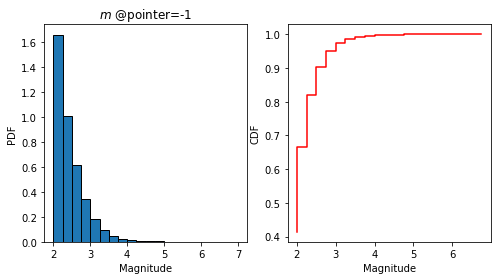

In [3]:
df['mag'][df['pointer']==-1]

fig0, axs = plt.subplots(1,2,figsize=(8,4))
#axs[0].set_yscale('log')
axs[0].set_xlabel('Magnitude')
axs[0].set_ylabel('PDF')
axs[0].set_title('$m$ @pointer=-1')
counts, bins, bars = axs[0].hist(df['mag'][df['pointer']==-1], bins=np.linspace(2,7,25-4),edgecolor='black',density=1)
axs[1].step(bins[:-1],counts.cumsum()/np.sum(counts),color='red')
axs[1].set_xlabel('Magnitude')
axs[1].set_ylabel('CDF');


Questo grafico mostra come i terremoti inidicizzati -1 (generatori) non sono quelli a maggiore terremoto (CDF plot utile se si usa il log-y space), nemmeno se considerassimo i segnali con m=2 come noise.

# Tree Algorithm

In [15]:
from matplotlib.ticker import MultipleLocator
mth=6
mask=(df['mag']>mth) & (df['pointer']!=-1)
i1 = df['pointer'][mask].to_numpy()
origin=0
nv=0
for i in range(len(i1)):
    mask1=[]
    mask1=[i1[i]]
    n=0
    while mask1[-1]!=-1:
        i2=df['pointer'][mask1[-1]] 
        mask1.append(i2)
        n=n+1
    nv=np.insert(nv,-1,n) 
    origin=np.insert(origin,-1,mask1[-2])
    
nv=np.delete(nv,-1)        #numero di step prima di arrivare all'evento generatore
origin=np.delete(origin,-1)#indici di riferimento dell'evento generatore


# Correlation between Time and Distance 

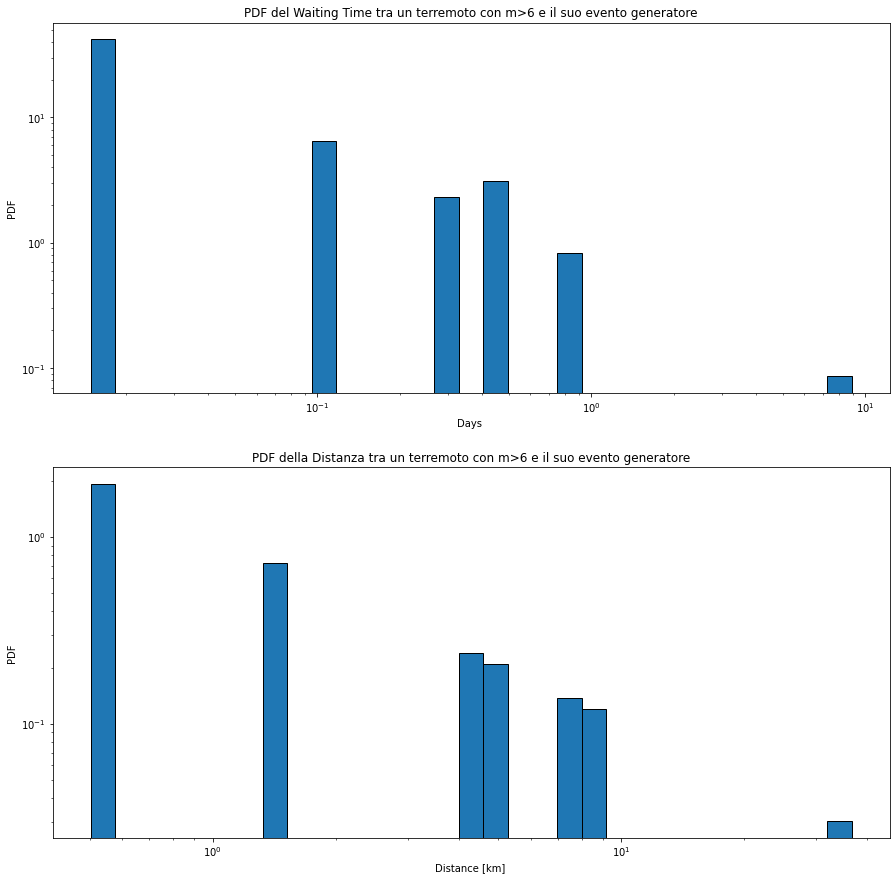

In [16]:
dtmc=df['t'][mask].to_numpy()-df['t'][origin].to_numpy()

x1=(df['lat'][mask].to_numpy()-df['lat'][origin].to_numpy())**2
y1=(df['long'][mask].to_numpy()-df['long'][origin].to_numpy())**2
z1=(df['dep'][mask].to_numpy()-df['dep'][origin].to_numpy())**2
drmc=(x1+y1+z1)**0.5
    
fig0, axs = plt.subplots(2,1,figsize=(15,15))
t1=np.max(dtmc)/c
r1=np.max(drmc)/1000
t0=np.min(dtmc)/c
r0=np.min(drmc)/1000

axs[0].set_xlabel('Days ')
axs[0].set_ylabel('PDF')
axs[0].set_title('PDF del Waiting Time tra un terremoto con m>%.0f e il suo evento generatore' %mth)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
counts, bins, bars = axs[0].hist(dtmc/c, bins=np.logspace(np.log10(t0),np.log10(t1),4*8),edgecolor='black',density=1)

axs[1].set_xlabel('Distance [km] ')
axs[1].set_ylabel('PDF')
axs[1].set_title('PDF della Distanza tra un terremoto con m>%.0f e il suo evento generatore' %mth)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
counts, bins, bars = axs[1].hist(drmc/1000, bins=np.logspace(np.log10(r0),np.log10(r1),4*8),edgecolor='black',density=1)


#LINEAR VERSION 
#counts, bins, bars = axs.hist(dtmc/c, bins=np.linspace(0,t1,70),edgecolor='black',density=1)
#axs.set_xlim(0,t1);
#axs.xaxis.set_minor_locator(MultipleLocator(30))
#axs.set_xticks([7,30*3,30*6,365,365*2])
#axs.set_xticklabels(['1w','3mth','6mth','1y','2y']);

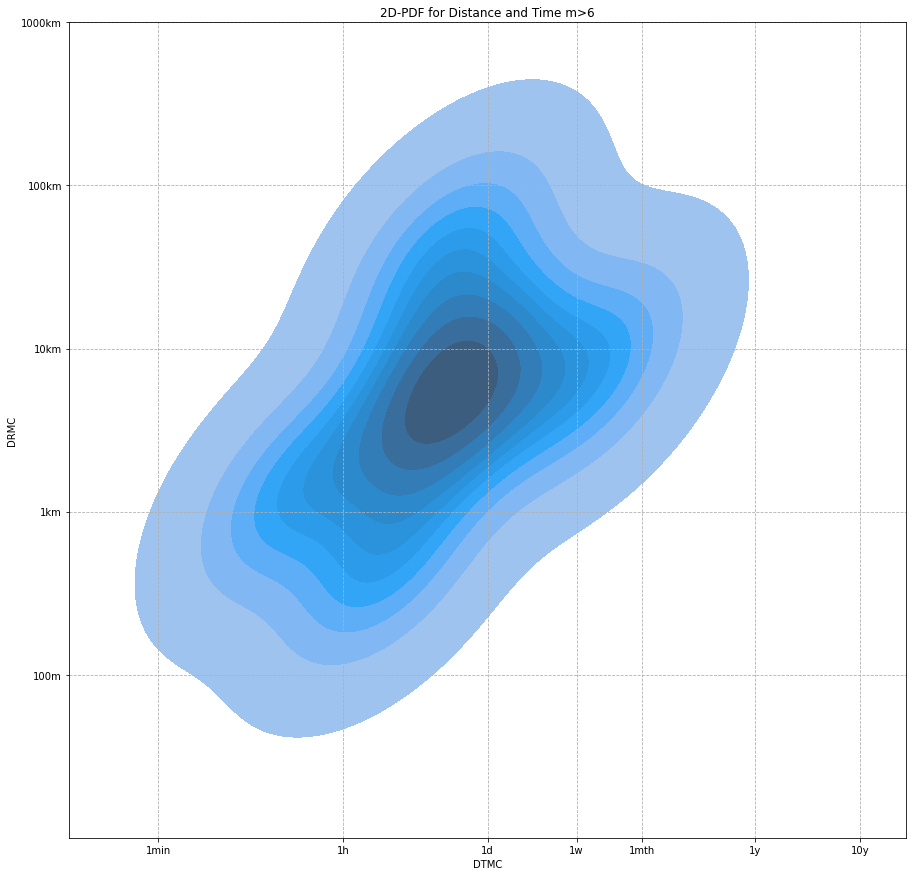

In [17]:
import seaborn as sns
fig0, ax = plt.subplots(figsize=(15,15))
dfr=pd.DataFrame({'dtmc': dtmc/c, 'drmc': drmc/1000})
sns.kdeplot(x=np.log10(dfr['dtmc']), y=np.log10(dfr['drmc']),fill='true',ax=ax,
            levels=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]);
ax.set_xlabel('DTMC');
ax.set_ylabel('DRMC');
ax.set_title('2D-PDF for Distance and Time m>%.0f'%mth)
ax.set_xticks([-3.15,-1.38,0,0.85,1.48,2.56,3.56]) #-3.15 -> 1min  -- -4.93 -> 1sec
ax.set_xticklabels(['1min','1h','1d','1w','1mth','1y','10y']);
ax.set_yticks([-1,0,1,2,3,4])
ax.set_yticklabels(['100m','1km','10km','100km','1000km','10000km']);
ax.set_xlim(-4,4);
ax.set_ylim(-2,3);
ax.grid(which='both',b=1, linestyle='dashed')
